In [8]:
# Windowing experiment
from typing import Dict, List, Optional
import tensorflow as tf
import os

In [7]:
def _tfrecord_feature_spec(
    float_feature_names: List[str],
) -> Dict[str, tf.io.FixedLenFeature]:
    # We parse only what we need for training; string timestamps are ignored.
    spec = {name: tf.io.FixedLenFeature([], tf.float32) for name in float_feature_names}
    # If you ever need timestamps, you can add:
    # spec["start_time"] = tf.io.FixedLenFeature([], tf.string)
    # spec["load_time_toronto"] = tf.io.FixedLenFeature([], tf.string)
    return spec

def _parse_example(serialized, feature_spec, feature_order: List[str]):
    parsed = tf.io.parse_single_example(serialized, feature_spec)
    # Assemble features in a fixed order -> vector [n_features]
    x = tf.stack([parsed[name] for name in feature_order], axis=-1)
    return x  # shape: [n_features], dtype float32


def _make_forecasting_dataset_from_tfrecord_dir(
    data_dir: str,
    *,
    input_width: int,          # L
    label_width: int,          # H (multi-step length); use 1 for single-point
    feature_names: List[str],
    label_name: str,           # e.g. hparams["label_name"] == "PRICE_std"
    shift: int = 0,            # gap between input end and label start (0 => labels start immediately after inputs)
    batch_size: int = 128,
    shuffle_sequences: bool = True,
    compression_type: str = "GZIP",
) -> tf.data.Dataset:
    """
    Returns a dataset of (x, y) pairs:
      x: [batch, input_width, n_features]
      y: [batch, label_width]  (single target feature only, chosen by label_name)

    The total chunk length is input_width + shift + label_width.
    Example (shift=0):
      [t0 .. t49] -> [t50 .. t99]

    Example (shift=5):
      inputs: [t0 .. t49]
      gap:    [t50 .. t54]  (ignored)
      labels: [t55 .. t104]
    """
    total_window = input_width + shift + label_width
    label_idx = feature_names.index(label_name)

    pattern = os.path.join(
        data_dir, "*.tfrecord.gz" if compression_type == "GZIP" else "*.tfrecord"
    )
    files = tf.data.Dataset.list_files(pattern, shuffle=False)

    # Stream the shards deterministically
    ds = files.interleave(
        lambda fp: tf.data.TFRecordDataset(fp, compression_type=compression_type),
        cycle_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    feature_spec = _tfrecord_feature_spec(feature_names)
    ds = ds.map(
        lambda s: _parse_example(s, feature_spec, feature_names),  # -> [n_features]
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Window into contiguous chunks of length total_window, stride 1
    ds = ds.window(size=total_window, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(total_window, drop_remainder=True))  # -> [T_total, F]

    # Split into (inputs, labels)
    def split_window(chunk: tf.Tensor):
        # chunk: [total_window, n_features]
        x = chunk[:input_width, :]  # [L, F]
        # labels start after input_width + shift
        y_start = input_width + shift
        y = chunk[y_start : y_start + label_width, label_idx]  # [H]
        return x, y

    ds = ds.map(split_window, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle_sequences:
        ds = ds.shuffle(buffer_size=10000, reshuffle_each_iteration=True)

    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [31]:
features = [
        "PRICE_std",
        "vol_quote_std",
        "cvd_quote_std",
        "PDCC_Down",
        "OSV_Down_std",
        "PDCC2_UP",
        "regime_up",
        "regime_down",
    ]
test_xy = _make_forecasting_dataset_from_tfrecord_dir(
        data_dir="gs://derivatives-417104-pl-root/255646047283/dc-vae-train-pipeline-20251014035639/tf-data-splitter_-2898744380930129920/test_data",
        input_width=50,
        label_width=10,
        shift=10,
        batch_size=128,
        feature_names=features,
        label_name='PRICE_std',
        shuffle_sequences=True,
        compression_type="GZIP",
    )

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Take a single batch from your dataset ---
first_batch = next(iter(test_xy))   # (x, y)
x_b, y_b = first_batch              # x: [B, L, F], y: [B, H]
B, L, F = x_b.shape
H = y_b.shape[1]
print(f"x batch shape: {x_b.shape}  (Batch size={B}, Input width={L}, Num Features={F})")
print(f"y batch shape: {y_b.shape}  (Batch size={B}, Label width={H})")

# --- Show first example numerically (head) ---
example_ix = 0
df = pd.DataFrame(x_b[example_ix].numpy(), columns=features)
print("Inputs head (first 5 timesteps):")
display(df.head())
print("Inputs tail (last 5 timesteps):")
display(df.tail())

print("Label vector (should be length = label_width):")
print(y_b[example_ix].numpy())


x batch shape: (128, 50, 8)  (Batch size=128, Input width=50, Num Features=8)
y batch shape: (128, 10)  (Batch size=128, Label width=10)
Inputs head (first 5 timesteps):


,PRICE_std,vol_quote_std,cvd_quote_std,PDCC_Down,OSV_Down_std,PDCC2_UP,regime_up,regime_down
0,2.424026,-0.155182,1.861645,0.0,-0.363857,0.0,1.0,0.0
1,2.432534,-0.158856,1.861929,0.0,-0.363857,0.0,1.0,0.0
2,2.407127,-0.149074,1.861712,0.0,-0.363857,0.0,1.0,0.0
3,2.408833,-0.148840,1.861459,0.0,-0.363857,0.0,1.0,0.0
4,2.437398,-0.158416,1.861581,0.0,-0.363857,0.0,1.0,0.0


Inputs tail (last 5 timesteps):


,PRICE_std,vol_quote_std,cvd_quote_std,PDCC_Down,OSV_Down_std,PDCC2_UP,regime_up,regime_down
45,2.547902,-0.112210,1.853484,0.0,-0.363857,0.0,1.0,0.0
46,2.526552,-0.124257,1.853377,0.0,-0.363857,0.0,1.0,0.0
47,2.522403,-0.158856,1.853449,0.0,-0.363857,0.0,1.0,0.0
48,2.522379,-0.161359,1.853505,0.0,-0.363857,0.0,1.0,0.0
49,2.484442,-0.160161,1.853607,0.0,-0.363857,0.0,1.0,0.0


Label vector (should be length = label_width):
[2.450701  2.4775949 2.4530525 2.4575024 2.4867017 2.5274055 2.5254457
 2.5197742 2.5249617 2.5256648]


In [33]:
def make_debug_ds(
    data_dir: str,
    *,
    input_width: int,
    label_width: int,
    feature_names: list,
    label_name: str,
    shift: int = 0,
    compression_type: str = "GZIP",
):
    total_window = input_width + shift + label_width
    label_idx = feature_names.index(label_name)

    pattern = os.path.join(
        data_dir, "*.tfrecord.gz" if compression_type == "GZIP" else "*.tfrecord"
    )
    files = tf.data.Dataset.list_files(pattern, shuffle=False)
    ds = files.interleave(
        lambda fp: tf.data.TFRecordDataset(fp, compression_type=compression_type),
        cycle_length=1, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True,
    )

    feature_spec = _tfrecord_feature_spec(feature_names)
    ds = ds.map(lambda s: _parse_example(s, feature_spec, feature_names),
                num_parallel_calls=tf.data.AUTOTUNE)  # -> [F]

    ds = ds.window(size=total_window, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(total_window, drop_remainder=True))  # [T_total, F]

    def split_debug(chunk):
        x = chunk[:input_width, :]                         # [L, F]
        tgt_chunk = chunk[:, feature_names.index(label_name)]  # [total_window]
        y = tgt_chunk[input_width + shift: input_width + shift + label_width]  # [H]
        return x, y, tgt_chunk

    return ds.map(split_debug, num_parallel_calls=tf.data.AUTOTUNE)


In [34]:
L, Sh, H = 50, 10, 10
debug_ds = make_debug_ds(
    data_dir="gs://derivatives-417104-pl-root/255646047283/dc-vae-train-pipeline-20251014035639/tf-data-splitter_-2898744380930129920/test_data",
    input_width=L, label_width=H, shift=Sh,
    feature_names=features, label_name="PRICE_std", compression_type="GZIP",
)

for i, (x_seq, y_seq, tgt_chunk) in enumerate(debug_ds.take(5)):
    x_seq, y_seq, tgt_chunk = x_seq.numpy(), y_seq.numpy(), tgt_chunk.numpy()
    expected = tgt_chunk[L+Sh : L+Sh+H]
    assert np.allclose(y_seq, expected), f"Mismatch at example {i}"
    print(f"Example {i}: OK")


Example 0: OK
Example 1: OK
Example 2: OK
Example 3: OK
Example 4: OK


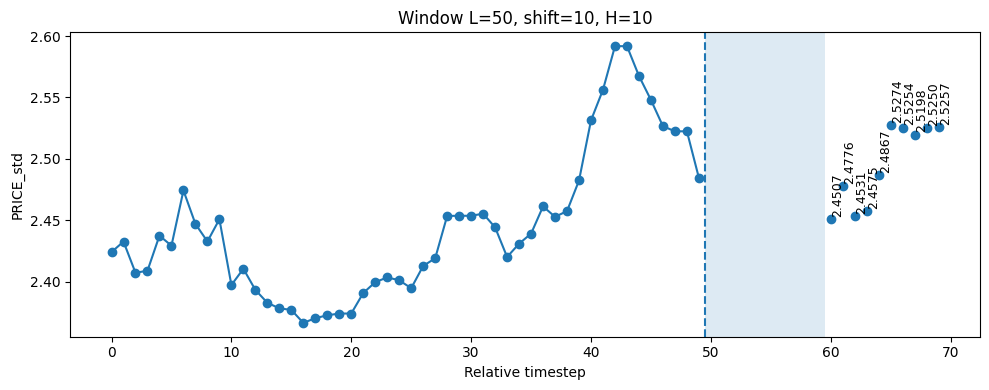

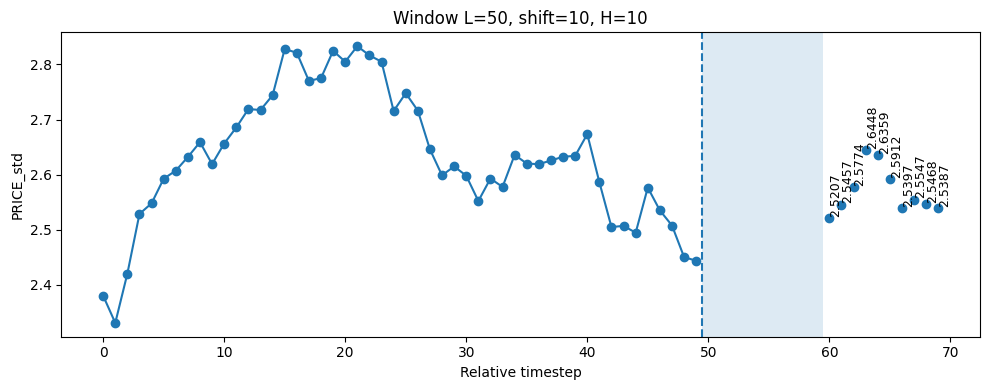

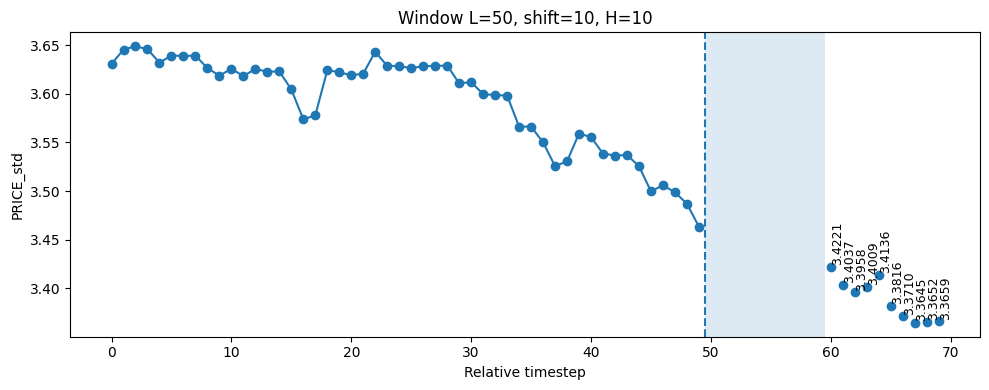

In [37]:
target = 'PRICE_std'
label_idx = features.index(target)

def plot_window(
    x_seq,
    y_seq,
    *,
    input_width,
    shift,
    label_width,
    title="",
    show_labels=True,
    label_rotation=85
):
    """
    x_seq: [L, F]
    y_seq: [H]
    """
    L = input_width
    H = label_width
    xs = np.arange(L)
    ys = np.arange(L + shift, L + shift + H)

    x_target = x_seq[:, label_idx]

    plt.figure(figsize=(10, 4))

    # Plot input target time series
    plt.plot(xs, x_target, marker='o')

    # Mark end of input window
    plt.axvline(x=L - 0.5, linestyle='--')

    # Shade gap region
    if shift > 0:
        plt.axvspan(L-0.5, L+shift-0.5, alpha=0.15)

    # Forecast points
    plt.scatter(ys, y_seq, zorder=3)

    # Optional label annotation
    if show_labels:
        for xi, yi, val in zip(ys, y_seq, y_seq):
            plt.text(
                xi,
                yi + (0.002 if yi >= 0 else -0.002),  # small offset up/down
                f"{float(val):.4f}",
                fontsize=9,
                ha='left',
                va='bottom',
                rotation=label_rotation
            )

    plt.title(title or f"Window L={L}, shift={shift}, H={H}")
    plt.xlabel("Relative timestep")
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()

# Plot examples
for i in range(min(3, B)):
    plot_window(
        x_b[i].numpy(), y_b[i].numpy(),
        input_width=50, shift=10, label_width=10,
        show_labels=True,
        label_rotation=90,
        # title=f"Example {i}"
    )